### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [11]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        #print(left_mask.shape, x.shape, y.shape, x[:, feature_id].shape)
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        max_Q = 0
        best_feature_id = 0
        threshold = x[0, 0]
        for i in range(len(self.features)): #перебор всех фичей
            feature_values = np.sort(np.unique(x[:, i]))
            for d in range(feature_values.shape[0]): #перебор порогов
                #print(i, d)
                if d > 0:
                    if y[d] == y[d - 1]:
                        continue
                thresh = feature_values[d]
                xleft, xright, yleft, yright = self.__div_samples(x, y, i, thresh)
                if min(xleft.shape[0], xright.shape[0]) < self.min_samples_split:
                    continue
                Nl = yleft.shape[0]
                Nr = yright.shape[0]
                Nm = y.shape[0]
                pl_classes = np.bincount(yleft, minlength = self.num_class)/Nl
                pr_classes = np.bincount(yright, minlength = self.num_class)/Nr
                pm_classes = np.bincount(y, minlength = self.num_class)/Nm
                
                if self.criterion == 'gini':
                    Fm = 1 - np.sum(pm_classes**2)
                    Fl = 1 - np.sum(pl_classes**2)
                    Fr = 1 - np.sum(pr_classes**2)
                elif self.criterion == 'entropy':
                    Fm = -np.sum(pm_classes*np.log(pm_classes))
                    Fl = -np.sum(pl_classes*np.log(pl_classes))
                    Fr = -np.sum(pr_classes*np.log(pr_classes))
                elif self.criterion == 'mistake':
                    Fm = 1 - pm_classes.max()
                    Fl = 1 - pl_classes.max()
                    Fr = 1 - pr_classes.max()
                Q = Fm - (Nl/Nm)*Fl - (Nr/Nm)*Fr
                if Q > max_Q:
                    Q_prev = max_Q
                    max_Q = Q
                    best_feature_id = i
                    threshold = thresh

        self.features[best_feature_id] += max_Q
        return best_feature_id, threshold

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        
        if (len(x) <= self.min_samples_split) or (depth == self.max_depth) or (np.unique(y).size < 2):
            pred_class = np.where(np.bincount(y) == np.bincount(y).max())[0][0]
            class_proba = len(y[y == pred_class])/len(y)
            self.tree[node_id] = (self.LEAF_TYPE, pred_class, class_proba)
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
            if min(x_left.shape[0], x_right.shape[0]) < self.min_samples_split:
                pred_class = np.where(np.bincount(y) == np.bincount(y).max())[0][0]
                class_proba = len(y[y == pred_class])/len(y)
                self.tree[node_id] = (self.LEAF_TYPE, pred_class, class_proba)
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold)
                self.__fit_node(x_left, y_left, 2*node_id + 1, depth + 1)
                self.__fit_node(x_right, y_right, 2*node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.features = dict.fromkeys(list(range(x.shape[1])), 0)
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.features
            

In [124]:
a = np.asarray([0])

In [125]:
np.bincount(a)

array([1], dtype=int64)

In [18]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [13]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
X_train.shape

(160, 13)

In [14]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [15]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [19]:
%time clf.fit(X_train, y_train)

Wall time: 1.3 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [20]:
%time my_clf.fit(X_train, y_train)

Wall time: 73.8 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [21]:
df = pd.read_csv('speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

In [22]:
df = df.drop(['id', 'idg', 'condtn', 'position', 'positin1', 'order', 'partner', 'from', 
              'zipcode', 'age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o', 'undergra',
              'mn_sat', 'income', 'tuition', 'expnum'], axis=1)


In [23]:
df = df.dropna(subset=['age'])

In [24]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [25]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)

In [26]:
for i in range(1, 20):
    col = 'is_field_code' + str(i)
    df[col] =  np.array(df.field_cd == i).astype(int)

In [27]:
df = df.drop(['field_cd'], axis=1)

In [ ]:
#df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

In [28]:
for i in range(1, 7):
    col = 'is_race' + str(i)
    df[col] = np.array(df.race == i).astype(int)

In [29]:
df = df.drop(['race'], axis = 1)

In [30]:
df = df.dropna(subset=['imprelig', 'imprace'])

In [31]:
df.drop_duplicates('iid').loc[:, 'date'].isnull().sum()

1

In [32]:
df = df.dropna(subset=['date'])

In [33]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [34]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [35]:
df = df.drop(['career'], axis=1)

In [36]:
for i in range(1, 19):
    col = 'is_career' + str(i)
    df[col] = np.array(df.career_c == i).astype(int)

In [37]:
df = df.drop(['career_c'], axis = 1)

In [38]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [39]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [40]:
df = df.drop(['exphappy'], axis=1)

In [41]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [42]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [43]:
temp.head()

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
0,1,1,15.0,20.0,20.0,15.0,15.0,15.0
10,2,1,45.0,5.0,25.0,20.0,0.0,5.0
20,3,1,35.0,10.0,35.0,10.0,10.0,0.0
30,4,1,20.0,20.0,20.0,20.0,10.0,10.0
40,5,1,20.0,5.0,25.0,25.0,10.0,15.0


In [44]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [45]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)

In [46]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
918,67,3,20.0,15.0,20.0,20.0,5.0,10.0,90.0
1530,105,4,30.0,15.0,20.0,20.0,0.0,5.0,90.0
7221,489,19,20.0,10.0,20.0,20.0,20.0,0.0,90.0
7586,517,21,15.0,20.0,20.0,20.0,5.0,10.0,90.0
7784,526,21,10.0,10.0,30.0,20.0,10.0,15.0,95.0


In [47]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [48]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
1846,132,6,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1851,133,6,12.77,19.15,17.02,17.02,14.89,19.15,100.00
1856,134,6,6.67,20.00,20.00,17.78,20.00,15.56,100.01
1861,135,6,18.18,22.73,18.18,13.64,13.64,13.64,100.01
1871,137,6,17.39,17.39,15.22,17.39,13.04,19.57,100.00
...,...,...,...,...,...,...,...,...,...
3308,229,9,21.43,16.67,21.43,16.67,11.90,11.90,100.00
3328,230,9,23.81,23.81,23.81,23.81,2.38,2.38,100.00
3348,231,9,18.60,20.93,23.26,23.26,2.33,11.63,100.01
3368,232,9,17.78,17.78,17.78,17.78,13.33,15.56,100.01


In [49]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [50]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [51]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']]

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
0,15.0,20.0,20.0,15.0,15.0,15.0
1,15.0,20.0,20.0,15.0,15.0,15.0
2,15.0,20.0,20.0,15.0,15.0,15.0
3,15.0,20.0,20.0,15.0,15.0,15.0
4,15.0,20.0,20.0,15.0,15.0,15.0
...,...,...,...,...,...,...
8373,70.0,0.0,15.0,15.0,0.0,0.0
8374,70.0,0.0,15.0,15.0,0.0,0.0
8375,70.0,0.0,15.0,15.0,0.0,0.0
8376,70.0,0.0,15.0,15.0,0.0,0.0


In [52]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

In [53]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [54]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [55]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

In [56]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
4816,320,12,20.0,10.0,10.0,10.0,20.0,10.0,80.0


In [57]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [58]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
1846,132,6,22.73,15.91,13.64,15.91,13.64,18.18,100.01
1851,133,6,24.32,16.22,13.51,16.22,10.81,18.92,100.00
1856,134,6,20.51,15.38,12.82,20.51,12.82,17.95,99.99
1861,135,6,18.75,16.67,14.58,18.75,18.75,12.50,100.00
1871,137,6,14.89,17.02,17.02,17.02,14.89,19.15,99.99
...,...,...,...,...,...,...,...,...,...
3308,229,9,15.22,19.57,15.22,17.39,21.74,10.87,100.01
3328,230,9,16.67,16.67,16.67,16.67,16.67,16.67,100.02
3348,231,9,18.18,11.36,15.91,18.18,20.45,15.91,99.99
3368,232,9,19.15,17.02,17.02,17.02,14.89,14.89,99.99


In [59]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [60]:
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [61]:
df = df.drop(['temp_totalsum'], axis=1)

In [62]:
print(list(df.columns))

['iid', 'gender', 'wave', 'round', 'pid', 'match', 'int_corr', 'samerace', 'age', 'imprace', 'imprelig', 'goal', 'date', 'go_out', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met', 'match_es', 'attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s', 'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s', 'satis_2', 'length', 'numdat_2', 'attr7_2', 'sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2', 'shar7_2', 'attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2', 'shar1_2', 'attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2', 'shar4_2', 'attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2', 'shar2_2', 'attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2', 'attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2', 'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3', 'attr1_3', 'sinc1_

In [63]:
df = df.drop(['match_es'], axis = 1)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8249 entries, 0 to 8377
Columns: 171 entries, iid to is_career18
dtypes: float64(121), int32(43), int64(7)
memory usage: 9.8 MB


In [65]:
df = df.drop(['wave'], axis=1)

In [66]:
df.shape

(8249, 170)

In [67]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .fillna(-1)
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .fillna(-1)
        
df_female.columns = df_female.columns + '_f'

In [68]:
df_male.shape

(4146, 169)

In [69]:
df_female.shape

(268, 166)

In [70]:
X = df_male.merge(df_female, left_on = 'pid', right_on = 'iid_f')

In [71]:
X.shape

(4056, 335)

In [72]:
y = X.match

In [81]:
X.columns[:10]

Index(['iid', 'round', 'pid', 'match', 'int_corr', 'samerace', 'age',
       'imprace', 'imprelig', 'goal'],
      dtype='object')

In [84]:
X = X.drop(['match', 'pid', 'iid'], axis = 1)

In [85]:
X.values

array([[ 1.0e+01,  1.4e-01,  0.0e+00, ...,  0.0e+00,  0.0e+00,  1.0e+00],
       [ 1.0e+01,  5.4e-01,  0.0e+00, ...,  0.0e+00,  0.0e+00,  1.0e+00],
       [ 1.0e+01,  1.6e-01,  1.0e+00, ...,  0.0e+00,  0.0e+00,  1.0e+00],
       ...,
       [ 2.2e+01, -2.0e-01,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 2.2e+01, -3.2e-01,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 2.2e+01,  1.0e-02,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00]])

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [86]:
from sklearn.model_selection import train_test_split, KFold

In [87]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [88]:
%%time
crit_list = ['gini', 'entropy', 'mistake']
crit_score = {}
for train_index, test_index in kf.split(X.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    for criterion in crit_list:
        my_clf = MyDecisionTreeClassifier(criterion = criterion, min_samples_split=2)
        my_clf.fit(X_train, y_train)
        score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
        if criterion not in crit_score:
            crit_score[criterion] = []
        else:
            crit_score[criterion].append(score)

C:\Users\Daria\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
C:\Users\Daria\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\Daria\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log
C:\Users\Daria\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in multiply


Wall time: 17min 16s


In [141]:
#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [89]:
crit_score

{'gini': [0.8545006165228114,
  0.8668310727496917,
  0.8569667077681874,
  0.8335388409371147],
 'entropy': [0.8199753390875463,
  0.8397040690505548,
  0.8483353884093712,
  0.8273736128236745],
 'mistake': [0.8199753390875463,
  0.843403205918619,
  0.843403205918619,
  0.8347718865598027]}

In [90]:
clf = DecisionTreeClassifier(min_samples_split=2)
clf.fit(X_train, y_train)
boxscore = accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
boxscore

0.8249075215782984

In [93]:
#подбор глубины
depth_score = {}
for train_index, test_index in kf.split(X.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    for depth in [3, 5, 7, 9, 11, 15, 20]:
        my_clf = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split=2, max_depth = depth)
        my_clf.fit(X_train, y_train)
        score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
        if depth not in depth_score:
            depth_score[depth] = [score]
        else:
            depth_score[depth].append(score)
    

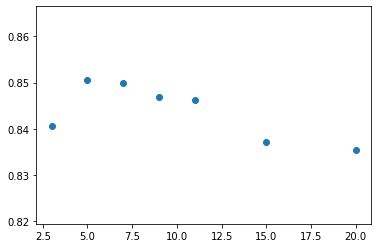

In [107]:
#графики с глубиной
plt.scatter(x = depth_score.keys(), y = [sum(i)/len(i) for i in depth_score.values()])

In [95]:
#подбор минсплита
split_score = {}
for train_index, test_index in kf.split(X.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    for minsplit in range(1, 20):
        my_clf = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split=minsplit)
        my_clf.fit(X_train, y_train)
        score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
        if minsplit not in split_score:
            split_score[minsplit] = [score]
        else:
            split_score[minsplit].append(score)
        

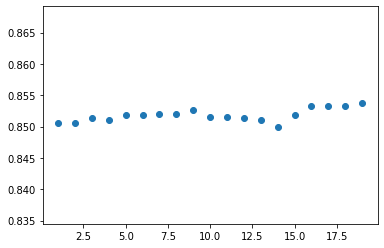

In [108]:
#графики
plt.scatter(x = split_score.keys(), y = [sum(i)/len(i) for i in split_score.values()])

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [109]:
final_score = []
important_features_cv = {}
c = 0
for train_index, test_index in kf.split(X.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    my_clf = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split=9, max_depth = 5)
    my_clf.fit(X_train, y_train)
    score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    final_score.append(score)
    feat_Q = my_clf.get_feature_importance()
    important_features = []
    for feat in feat_Q:
        if feat_Q[feat] > 0:
            important_features.append(feat)
        important_features_cv[c] = important_features
    c += 1

In [111]:
#максимальная достигнутая точность
sum(final_score)/len(final_score)

0.8525657067538098

In [115]:
#посмотрим, какие признаки оказались важными на всех фолдах
from functools import reduce
super_features = reduce(lambda x, y: set(x) & set(y), important_features_cv.values())

In [116]:
X.iloc[:, list(super_features)]

,dec_f,shar1_s,dec
0,1,-1.0,0
1,1,-1.0,0
2,1,-1.0,1
3,1,-1.0,1
4,1,-1.0,1
...,...,...,...
4051,1,-1.0,0
4052,1,-1.0,0
4053,1,-1.0,0
4054,1,-1.0,0


In [ ]:
#Что-то про общие интересы и decision at night of event, не очень честный признак, выкинем его

In [117]:
X = X.drop(['dec', 'dec_f'], axis = 1)

In [118]:
final_score = []
important_features_cv = {}
c = 0
for train_index, test_index in kf.split(X.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    my_clf = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split=9, max_depth = 5)
    my_clf.fit(X_train, y_train)
    score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    final_score.append(score)
    feat_Q = my_clf.get_feature_importance()
    important_features = []
    for feat in feat_Q:
        if feat_Q[feat] > 0:
            important_features.append(feat)
        important_features_cv[c] = important_features
    c += 1

In [119]:
sum(final_score)/len(final_score)

0.8276672963500635

In [120]:
from functools import reduce
super_features = reduce(lambda x, y: set(x) & set(y), important_features_cv.values())

In [121]:
X.iloc[:, list(super_features)]

,like,prob,them_cal_f,go_out
0,7.0,4.0,1.0,4.0
1,8.0,4.0,1.0,1.0
2,10.0,10.0,1.0,1.0
3,7.0,7.0,1.0,1.0
4,8.0,6.0,1.0,1.0
...,...,...,...,...
4051,5.0,7.0,0.0,1.0
4052,4.0,4.0,0.0,1.0
4053,5.0,3.0,0.0,1.0
4054,7.0,5.0,0.0,3.0


In [122]:
X = X.drop(['like', 'prob'], axis = 1)

In [123]:
final_score = []
important_features_cv = {}
c = 0
for train_index, test_index in kf.split(X.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    my_clf = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split=9, max_depth = 5)
    my_clf.fit(X_train, y_train)
    score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    final_score.append(score)
    feat_Q = my_clf.get_feature_importance()
    important_features = []
    for feat in feat_Q:
        if feat_Q[feat] > 0:
            important_features.append(feat)
        important_features_cv[c] = important_features
    c += 1

In [124]:
sum(final_score)/len(final_score)

0.825205456986145

In [125]:
from functools import reduce
super_features = reduce(lambda x, y: set(x) & set(y), important_features_cv.values())

In [126]:
X.iloc[:, list(super_features)]

,fun,them_cal_f
0,8.0,1.0
1,7.0,1.0
2,10.0,1.0
3,8.0,1.0
4,6.0,1.0
...,...,...
4051,1.0,0.0
4052,7.0,0.0
4053,3.0,0.0
4054,7.0,0.0


In [ ]:
#them_cal опять не очень честная, зато есть fun

In [127]:
#посмотрим, какие вообще признаки выбирались
all_features = reduce(lambda x, y: set(x) | set(y), important_features_cv.values())

In [128]:
X.iloc[:, list(all_features)]

,imprelig,goal,date,go_out,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,...,shar1_2_f,intel2_2_f,fun2_2_f,amb2_2_f,shar2_2_f,them_cal_f,numdat_3_f,num_in_3_f,intel1_3_f,amb1_3_f
0,3.0,1.0,5.0,4.0,35.0,20.0,20.0,20.0,0.0,5.0,...,16.67,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,20.0,15.0
1,1.0,1.0,1.0,1.0,60.0,0.0,0.0,40.0,0.0,0.0,...,16.67,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,20.0,15.0
2,5.0,2.0,7.0,1.0,19.0,18.0,19.0,18.0,14.0,12.0,...,16.67,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,20.0,15.0
3,1.0,2.0,4.0,1.0,30.0,5.0,15.0,40.0,5.0,5.0,...,16.67,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,20.0,15.0
4,1.0,1.0,4.0,1.0,30.0,10.0,20.0,10.0,10.0,20.0,...,16.67,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,20.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4051,8.0,1.0,6.0,1.0,40.0,10.0,20.0,10.0,0.0,20.0,...,30.00,10.0,15.0,10.0,15.0,0.0,-1.0,-1.0,15.0,15.0
4052,3.0,1.0,7.0,1.0,20.0,20.0,20.0,20.0,0.0,20.0,...,30.00,10.0,15.0,10.0,15.0,0.0,-1.0,-1.0,15.0,15.0
4053,6.0,2.0,4.0,1.0,30.0,3.0,30.0,30.0,3.0,4.0,...,30.00,10.0,15.0,10.0,15.0,0.0,-1.0,-1.0,15.0,15.0
4054,1.0,1.0,6.0,3.0,40.0,20.0,20.0,20.0,0.0,0.0,...,30.00,10.0,15.0,10.0,15.0,0.0,-1.0,-1.0,15.0,15.0


In [129]:
len(X.columns)

328

In [130]:
final_score

[0.791871921182266,
 0.8236744759556104,
 0.8471023427866831,
 0.842170160295931,
 0.8212083847102343]

In [138]:
top_features = {}
c = 0
for train_index, test_index in kf.split(X.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    my_clf = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split=9, max_depth = 5)
    my_clf.fit(X_train, y_train)
    feat_Q = my_clf.get_feature_importance()
    indices = np.asarray(list(feat_Q.values())).argsort()[:-11:-1]
    top_features[c] = indices
    c += 1

In [143]:
X.iloc[:, list(top_features[2])]

,sinc2_1_f,amb1_1,amb3_2,is_race2_f,attr1_2,go_out,shar,fun,sinc,intel3_s_f
0,20.0,0.0,5.0,0,19.51,4.0,6.0,8.0,8.0,-1.0
1,20.0,0.0,-1.0,0,-1.00,1.0,5.0,7.0,8.0,-1.0
2,20.0,14.0,2.0,0,20.00,1.0,10.0,10.0,10.0,-1.0
3,20.0,5.0,9.0,0,20.00,1.0,8.0,8.0,8.0,-1.0
4,20.0,10.0,9.0,0,21.21,1.0,7.0,6.0,7.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
4051,10.0,0.0,8.0,0,40.00,1.0,1.0,1.0,10.0,-1.0
4052,10.0,0.0,8.0,0,20.00,1.0,6.0,7.0,7.0,-1.0
4053,10.0,3.0,7.0,0,60.00,1.0,2.0,3.0,7.0,-1.0
4054,10.0,0.0,5.0,0,75.00,3.0,6.0,7.0,9.0,-1.0


In [ ]:
#Общие интересы всё решают. Признаки смешные, но как-то очень сильно меняются от фолда к фолду. 
#Наверное, в таких случаях нужно делать bootstrap

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [ ]:
#Не получилось ускорить. Интересно было бы понять, как можно это сделать 
#